## Sentinel-1 Offset Tracking for glacier velocity maps

This application takes a number of Sentinel-1 stack products and identifies a possible reference product for flood change detection analysis 

### <a name="data">Data

SENTINEL data products are made available systematically and free of charge to all data users including the general public, scientific and commercial users. Radar data will be delivered within an hour of reception for Near Real-Time (NRT) emergency response, within three hours for NRT priority areas and within 24 hours for systematically archived data.

All data products are distributed in the SENTINEL Standard Archive Format for Europe (SAFE) format.

Data products are available in single polarisation (VV or HH) for Wave mode and dual polarisation (VV+VH or HH+HV) and single polarisation (HH or VV) for SM, IW and EW modes.

Level-1 Ground Range Detected (GRD) products consist of focused SAR data that has been detected, multi-looked and projected to ground range using an Earth ellipsoid model. Phase information is lost. The resulting product has approximately square resolution pixels and square pixel spacing with reduced speckle at the cost of reduced geometric resolution.

GRD products can be in one of three resolutions:

* Full Resolution (FR)
* High Resolution (HR)
* Medium Resolution (MR).

The resolution is dependent upon the amount of multi-looking performed. Level-1 GRD products are available in MR and HR for IW and EW modes, MR for WV mode and MR, HR and FR for SM mode.

### Workflow

In [1]:
import iplantuml

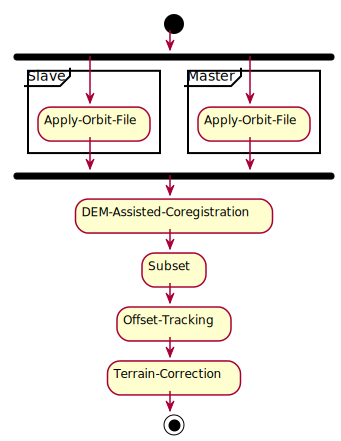

In [2]:
%%plantuml

@startuml

start

 fork
   partition "Slave" {
    :Apply-Orbit-File;
}
  fork again
   partition "Master" {
    :Apply-Orbit-File;
}
  end fork
    :DEM-Assisted-Coregistration;
    :Subset;
    :Offset-Tracking;
    :Terrain-Correction;


stop
@enduml

### <a name="service">Service definition

In [3]:
service = dict([('title', 'Sentinel-1 Offset Tracking for glacier velocity maps'),
                ('abstract', 'Sentinel-1 Offset Tracking for glacier velocity maps'),
                ('id', 'ewf-offset-tracking')])

### Service parameter definition

In [4]:
glacier_center = dict([('id', 'glacier_center'),
               ('value', '-35.3,83.9'),
               ('title', 'Glacier center (lon, lat)'),
               ('abstract', 'Glacier center (lon, lat)')])

In [5]:
geo_extent = dict([('id', 'geo_extent'),
               ('value', '50000'),
               ('title', 'Extent around the glacier center in meters'),
               ('abstract', 'Extent around the glacier center in meters')])

### <a name="runtime">Runtime parameter definition

**Input identifiers**

This is the Sentinel-1 stack of products' identifiers.

In order to generate glacier velocity map using the Offset Tracking tool, the input products must
be two GRD products over the same area acquired at different times. 

The time interval should be as short as possible. 

In [6]:
import pandas as pd
from geopandas import GeoDataFrame
from shapely.wkt import loads
import cioppy
import numpy as np
from datetime import datetime
import gdal
%matplotlib inline
import matplotlib.pyplot as plt

Read the CSV containing the selected Sentinel-1 acquisition

In [7]:
s1_prds = GeoDataFrame(pd.read_csv('s1_prd.csv'))

Cleanse it

In [8]:
s1_prds['startdate'] = pd.to_datetime(s1_prds['startdate'])  

In [9]:
s1_prds['wkt'] = s1_prds['wkt'].apply(loads)

In [10]:
s1_prds = s1_prds.drop(['Unnamed: 0'], axis=1)

Now it looks like:

In [11]:
s1_prds

,enclosure,identifier,self,startdate,track,wkt,local_path
0,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T114138_20180822T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22 11:41:38.660,99,"POLYGON ((-37.121357 81.783356, -61.739033 84....",/data2/S1B_EW_GRDM_1SDH_20180822T114138_201808...


Search for a Sentinel-1 pair a cycle (twelve days) before with the same track and covering its footprint:

In [12]:
start_time = (s1_prds.iloc[0]['startdate'] - np.timedelta64(12, 'D')).isoformat() + 'Z'

stop_time = (s1_prds.iloc[0]['startdate'] - np.timedelta64(1, 'D')).isoformat() + 'Z'
                        
wkt = s1_prds.iloc[0]['wkt'].wkt
track =  s1_prds.iloc[0]['track']


search_params = dict([('geom', wkt),
                      ('start', start_time),
                      ('stop', stop_time),
                      ('track', track),
                      ('pt', 'GRD')])

print search_params 

series = 'https://catalog.terradue.com/sentinel1/search'

ciop = cioppy.Cioppy()

search = GeoDataFrame(ciop.search(end_point=series, 
                     params=search_params,
                     output_fields='identifier,enclosure,self,startdate,track,wkt',
                     model='EOP'))
                            

{'stop': '2018-08-21T11:41:38.660000Z', 'start': '2018-08-10T11:41:38.660000Z', 'geom': 'POLYGON ((-37.121357 81.783356, -61.739033 84.10655199999999, -31.865376 86.972076, -11.720141 83.541039, -37.121357 81.783356))', 'pt': 'GRD', 'track': 99}


Update the _wkt_ column to a geometry:

In [13]:
search['wkt'] = search['wkt'].apply(loads)

Append the found Sentinel-1 products to our originally selected Sentinel-1 acquisition:

In [14]:
s1_prds = s1_prds.append(search) 

Reset its index

In [15]:
s1_prds = s1_prds.reset_index().drop(['index'], axis=1)

Define a function to determine the overlap between acquisition footprints

In [16]:
def analyse(row, aoi_wkt):
    
    coverage = row['wkt'].area/ aoi_wkt.area * 100
    
    return coverage
    

Add a new column with the coverage percent by applying the function above


In [17]:
s1_prds['coverage'] = s1_prds.apply(lambda row: analyse(row, s1_prds.iloc[0]['wkt']), axis=1)


Now the Sentinel-1 data frame looks like:

In [18]:
s1_prds

,enclosure,identifier,local_path,self,startdate,track,wkt,coverage
0,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T114138_20180822T1142...,/data2/S1B_EW_GRDM_1SDH_20180822T114138_201808...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22 11:41:38.660000,99,"POLYGON ((-37.121357 81.783356, -61.739033 84....",100.000000
1,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDH_1SDH_20180810T114237_20180810T1143...,NaN,https://catalog.terradue.com/sentinel1/search?...,2018-08-10T11:42:37.7547440Z,99,"POLYGON ((-52.067234 79.08316000000001, -71.51...",69.685332
2,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180810T114237_20180810T1143...,NaN,https://catalog.terradue.com/sentinel1/search?...,2018-08-10T11:42:37.7554950Z,99,"POLYGON ((-52.065311 79.083237, -71.515289 80....",69.679648
3,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180810T114137_20180810T1142...,NaN,https://catalog.terradue.com/sentinel1/search?...,2018-08-10T11:41:37.7566730Z,99,"POLYGON ((-37.125397 81.78415699999999, -61.74...",100.012058


Select the slave acquisition at position 3:

In [19]:
s1_prds.iloc[3]['identifier']

'S1B_EW_GRDM_1SDH_20180810T114137_20180810T114237_012200_016799_1944'

Stage-in the product:

In [20]:
local_path  =ciop.copy(urls=s1_prds.iloc[3]['enclosure'], extract=False, target='/data2')

Update the *local_path* column with the newly downloaded product:

In [21]:
s1_prds.columns.get_loc('local_path')

2

In [22]:
s1_prds.iat[3, s1_prds.columns.get_loc('local_path')] = '/data2/S1B_EW_GRDM_1SDH_20180810T114137_20180810T114237_012200_016799_1944.zip'

Now the Sentinel-1 data frame looks like:

In [23]:
s1_prds

,enclosure,identifier,local_path,self,startdate,track,wkt,coverage
0,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T114138_20180822T1142...,/data2/S1B_EW_GRDM_1SDH_20180822T114138_201808...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22 11:41:38.660000,99,"POLYGON ((-37.121357 81.783356, -61.739033 84....",100.000000
1,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDH_1SDH_20180810T114237_20180810T1143...,NaN,https://catalog.terradue.com/sentinel1/search?...,2018-08-10T11:42:37.7547440Z,99,"POLYGON ((-52.067234 79.08316000000001, -71.51...",69.685332
2,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180810T114237_20180810T1143...,NaN,https://catalog.terradue.com/sentinel1/search?...,2018-08-10T11:42:37.7554950Z,99,"POLYGON ((-52.065311 79.083237, -71.515289 80....",69.679648
3,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180810T114137_20180810T1142...,/data2/S1B_EW_GRDM_1SDH_20180810T114137_201808...,https://catalog.terradue.com/sentinel1/search?...,2018-08-10T11:41:37.7566730Z,99,"POLYGON ((-37.125397 81.78415699999999, -61.74...",100.012058


The local files to process are thus:

In [24]:
local_paths = (s1_prds.iloc[[0,3],[s1_prds.columns.get_loc('local_path')]].values[0][0],
               s1_prds.iloc[[0,3],[s1_prds.columns.get_loc('local_path')]].values[1][0])

In [25]:
local_paths

('/data2/S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770.zip',
 '/data2/S1B_EW_GRDM_1SDH_20180810T114137_20180810T114237_012200_016799_1944.zip')

### <a name="workflow">Workflow

#### Import the packages required for processing the data

In [26]:
from snappy import jpy
from snappy import ProductIO
from snappy import GPF
from snappy import HashMap
from osgeo import ogr
from osgeo import osr
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import box
from shapely.wkt import loads
from shapely import geometry
import numpy as np
import ipyleaflet
from ipyleaflet import *

from ipywidgets import HTML

from datetime import datetime

import cioppy

import lxml.etree as etree



#### Read the products

In [27]:

products = []

for s1path in local_paths:

    
    reader = ProductIO.getProductReader("SENTINEL-1")
    product = reader.readProductNodes(s1path, None)
    products.append(product)

In [28]:
def get_snap_parameters(operator):
    
    op_spi = GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpi(operator)

    op_params = op_spi.getOperatorDescriptor().getParameterDescriptors()

    return op_params
    

### Apply orbit file SNAP Operator

The orbit state vectors provided in the metadata of a SAR product are generally not accurate and can be refined with the precise orbit files which are available days-to-weeks after the generation of the product. 

The orbit file provides accurate satellite position and velocity information. Based on this information, the orbit state vectors in the abstract metadata of the product are updated.

The Precise Orbit Determination (POD) service for SENTINEL-1 provides Restituted orbit files and Precise Orbit Ephemerides (POE) orbit files. POE files cover approximately 28 hours and contain orbit state vectors at fixed time steps of 10 seconds intervals. Files are generated one file per day and are delivered within 20 days after data acquisition. 

Get the parameters of the **Apply orbit file** SNAP Operator:

In [29]:
operator = 'Apply-Orbit-File'

operator_params = get_snap_parameters(operator)

Apply the operator:

In [30]:
parameters = HashMap()

for param in operator_params:
    
    print param.getName(), param.getDefaultValue()
    
    parameters.put(param.getName(), param.getDefaultValue())

master_orbit = GPF.createProduct(operator,
                                 parameters, 
                                 products[0])
    
slave_orbit = GPF.createProduct(operator,
                                 parameters, 
                                 products[1])

orbitType Sentinel Precise (Auto Download)
polyDegree 3
continueOnFail false


## DEM Assisted Coregistration

For Offset Tracking processing, two images must be coregistered into a stack. 

The image that was acquired earlier is selected as the master and the other image is selected as the slave. The pixels in slave image will be moved to align with the master image with the help of the orbital data and a reference DEM.

Coregistration ensures that each ground target from stationary scene contributes to the same (range, azimuth) pixel in both the master and the slave image.

For Offset Tracking application, DEM Assisted Coregistration is used. It coregisters the products strictly based on the geometry using a DEM, orbit positions and times. This avoids possibly warping the image incorrectly due to the movement in the scene.


In [31]:
operator = 'DEM-Assisted-Coregistration'

operator_params = get_snap_parameters(operator)

In [32]:
for param in operator_params:
    
    print param.getName(), param.getDefaultValue()

demName SRTM 3Sec
demResamplingMethod BICUBIC_INTERPOLATION
externalDEMFile None
externalDEMNoDataValue 0
resamplingType BISINC_5_POINT_INTERPOLATION
tileExtensionPercent 50
maskOutAreaWithoutElevation true
outputRangeAzimuthOffset false


The default DEM, which is SRTM 3 Sec, covers most area of the earth's surface between –60 degree latitude and +60 degree latitude. However, it does not cover the high latitude area where Rink Glacier is located. 

Therefore, ASTER GDEM, GETASSE30 or ACE30 DEM could be selected. 

In [33]:
for param in operator_params:
    
    if param.getName() == 'demName':
        
        param_value = 'ACE30'
    
    else:
    
        param_value = param.getDefaultValue()

    print param.getName(), param_value
    
    parameters.put(param.getName(), param_value)
    
dem_assisted_coregistration = GPF.createProduct(operator,
                                 parameters, 
                                 [master_orbit, slave_orbit])

demName ACE30
demResamplingMethod BICUBIC_INTERPOLATION
externalDEMFile None
externalDEMNoDataValue 0
resamplingType BISINC_5_POINT_INTERPOLATION
tileExtensionPercent 50
maskOutAreaWithoutElevation true
outputRangeAzimuthOffset false


### Subset

In [34]:
def convert_coords(source_epsg, target_epsg, geom):

    source = osr.SpatialReference()
    source.ImportFromEPSG(source_epsg)

    target = osr.SpatialReference()
    target.ImportFromEPSG(target_epsg)

    transform = osr.CoordinateTransformation(source, target)

    point = ogr.CreateGeometryFromWkt(geom)
    point.Transform(transform)

    return point.ExportToWkt()

In [35]:
def extend_aoi(center_x, center_y, extent):
    
    center_polar = loads(convert_coords(4326, 3995, Point(center_x, center_y).wkt))
    
    ll = convert_coords(3995, 4326, Point(center_polar.x - extent,  center_polar.y - extent).wkt)
    lr = convert_coords(3995, 4326, Point(center_polar.x + extent,  center_polar.y - extent).wkt)
    ur = convert_coords(3995, 4326, Point(center_polar.x + extent,  center_polar.y + extent).wkt)
    ul = convert_coords(3995, 4326, Point(center_polar.x - extent,  center_polar.y + extent).wkt)


    pointList = [loads(ll),
             loads(lr), 
             loads(ur), 
             loads(ul), 
             loads(ll)]

    extended_aoi = geometry.Polygon([[p.x, p.y] for p in pointList]).wkt
    
    return extended_aoi

In [36]:
glacier_center_x, glacier_center_y = [float(x) for x in glacier_center['value'].split(',')] 

In [37]:
aoi_wkt = extend_aoi(glacier_center_x, glacier_center_y, float(geo_extent['value']))

In [38]:
aoi_locations = np.asarray([t[::-1] for t in list(loads(aoi_wkt).exterior.coords)]).tolist()

In [39]:
map_center_x = loads(aoi_wkt).centroid.x
map_center_y = loads(aoi_wkt).centroid.y

In [40]:
m = Map(center=(loads(aoi_wkt).centroid.y, 
                loads(aoi_wkt).centroid.x), 
                zoom=8)

m += Polygon(locations=aoi_locations,
             color="green",
             fill_color="green",
             weight=1,
             fill_opacity=0.1)

mark = Marker(location=(glacier_center_y, glacier_center_x))

html_widget = HTML(
    value="""
        <div>
        Glacier
        </div>""",
    placeholder='',
    description='',
    )

mark.popup = html_widget

m.add_layer(mark)
m

TWFwKGJhc2VtYXA9eyd1cmwnOiAnaHR0cHM6Ly97c30udGlsZS5vcGVuc3RyZWV0bWFwLm9yZy97en0ve3h9L3t5fS5wbmcnLCAnbWF4X3pvb20nOiAxOSwgJ2F0dHJpYnV0aW9uJzogJ01hcCDigKY=


### Subset

parameters = HashMap()

#parameters.put('sourceBands', ['Amplitude_HH_mst_20Jul2016', 'Amplitude_HH_slv1_08Jul2016'])
#parameters.put('region', '')
parameters.put('geoRegion', aoi_wkt)
parameters.put('subSamplingX', '1')
parameters.put('subSamplingY', '1')
parameters.put('fullSwath', 'false')
parameters.put('tiePointGridNames', '')
parameters.put('copyMetadata', 'true')

subset = GPF.createProduct('Subset', parameters, dem_assisted_coregistration)

### Offset-Tracking

The Offset Tracking operator estimates the movement of glacier surfaces between master and slave images in both slant-range and azimuth direction. It performs cross-correlation on selected Ground Control Point (GCP) in master and slave images. 

Then the glacier velocities on the selected GCPs are computed based on the offsets estimated by the cross-correlation. Finally the glacier velocity map is generated through interpolation of the velocities computed on the GCP grid.

The Offset Tracking is performed in the following sub-steps:

* For each point in the user specified GCP grid in master image, compute its corresponding pixel position in slave image using normalized cross-correlation.
* If the compute offset between master and slave GCP positions exceeds the maximum offset (computed from user specified maximum velocity), then the GCP point is marked as outlier.
*  Perform local average for the offset on valid GCP points.
*  Fill holes caused by the outliers. The offset at hole point will be replaced by a new offset computed by local weighted average.
*  Compute the velocities for all points on GCP grid from their offsets.
*  Finally, compute velocities for all pixels in the master image from the velocities on GCP grid by interpolation.

The maximum velocity for Rink Glacier is around 10 meters per day. Given that the SAR image acquisition period is 12 days and range and azimuth spacing is 10 meters, we can calculate the maximum shift of a target in the glacier is about 12 pixel. We know that the default Registration Window dimension (128 pixels) is larger enough to cover the target in both master and slave images. 

In [41]:
operator = 'Offset-Tracking'

operator_params = get_snap_parameters(operator)

for param in operator_params:
    
    print param.getName(), param.getDefaultValue()

gridAzimuthSpacing 40
gridRangeSpacing 40
registrationWindowWidth 128
registrationWindowHeight 128
xCorrThreshold 0.1
averageBoxSize 5
maxVelocity 5.0
radius 4
resamplingType BICUBIC_INTERPOLATION
spatialAverage true
fillHoles true
roiVector None


In [42]:
for param in operator_params:
    
    if param.getName() == 'maxVelocity':
        
        param_value = '10'
    
    else:
    
        param_value = param.getDefaultValue()

    print param.getName(), param_value
    
    parameters.put(param.getName(), param_value)
    
offset_tracking = GPF.createProduct(operator,
                                 parameters, 
                                 dem_assisted_coregistration)

gridAzimuthSpacing 40
gridRangeSpacing 40
registrationWindowWidth 128
registrationWindowHeight 128
xCorrThreshold 0.1
averageBoxSize 5
maxVelocity 10
radius 4
resamplingType BICUBIC_INTERPOLATION
spatialAverage true
fillHoles true
roiVector None


### Terrain correction

In [43]:
operator = 'Terrain-Correction'

operator_params = get_snap_parameters(operator)

In [44]:
map_proj = """PROJCS["WGS 84 / Arctic Polar Stereographic", 
  GEOGCS["WGS 84", 
    DATUM["World Geodetic System 1984", 
      SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]], 
      AUTHORITY["EPSG","6326"]], 
    PRIMEM["Greenwich", 0.0, AUTHORITY["EPSG","8901"]], 
    UNIT["degree", 0.017453292519943295], 
    AXIS["Geodetic longitude", EAST], 
    AXIS["Geodetic latitude", NORTH], 
    AUTHORITY["EPSG","4326"]], 
  PROJECTION["Polar Stereographic (variant B)", AUTHORITY["EPSG","9829"]], 
  PARAMETER["central_meridian", 0.0], 
  PARAMETER["Standard_Parallel_1", 71.0], 
  PARAMETER["false_easting", 0.0], 
  PARAMETER["false_northing", 0.0], 
  UNIT["m", 1.0], 
  AXIS["Easting", "South along 90 deg East"], 
  AXIS["Northing", "South along 180 deg"], 
  AUTHORITY["EPSG","3995"]]"""

In [45]:
parameters = HashMap()

for param in operator_params:
    
    if param.getName() == 'demName':
        
        param_value = 'ACE30'
    
    elif param.getName() == 'mapProjection':
        
        param_value = map_proj
     
    elif param.getName() == 'nodataValueAtSea':
        
        param_value = 'false'
    
    else:
    
        param_value = param.getDefaultValue()

    print param.getName(), param_value
    
    parameters.put(param.getName(), param_value)

terrain = GPF.createProduct(operator,
                  parameters, 
                  offset_tracking)

sourceBandNames None
demName ACE30
externalDEMFile None
externalDEMNoDataValue 0
externalDEMApplyEGM true
demResamplingMethod BILINEAR_INTERPOLATION
imgResamplingMethod BILINEAR_INTERPOLATION
pixelSpacingInMeter 0
pixelSpacingInDegree 0
mapProjection PROJCS["WGS 84 / Arctic Polar Stereographic", 
  GEOGCS["WGS 84", 
    DATUM["World Geodetic System 1984", 
      SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]], 
      AUTHORITY["EPSG","6326"]], 
    PRIMEM["Greenwich", 0.0, AUTHORITY["EPSG","8901"]], 
    UNIT["degree", 0.017453292519943295], 
    AXIS["Geodetic longitude", EAST], 
    AXIS["Geodetic latitude", NORTH], 
    AUTHORITY["EPSG","4326"]], 
  PROJECTION["Polar Stereographic (variant B)", AUTHORITY["EPSG","9829"]], 
  PARAMETER["central_meridian", 0.0], 
  PARAMETER["Standard_Parallel_1", 71.0], 
  PARAMETER["false_easting", 0.0], 
  PARAMETER["false_northing", 0.0], 
  UNIT["m", 1.0], 
  AXIS["Easting", "South along 90 deg East"], 
  AXIS["Northing", "S

In [46]:
parameters = HashMap()

#parameters.put('sourceBands', ['Amplitude_HH_mst_20Jul2016', 'Amplitude_HH_slv1_08Jul2016'])
#parameters.put('region', '')
parameters.put('geoRegion', aoi_wkt)
parameters.put('subSamplingX', '1')
parameters.put('subSamplingY', '1')
parameters.put('fullSwath', 'false')
parameters.put('tiePointGridNames', '')
parameters.put('copyMetadata', 'true')

subset = GPF.createProduct('Subset', parameters, terrain)

### Write the product

In [ ]:
start_date = datetime.strptime(str(master_orbit.getStartTime()), '%d-%b-%Y %H:%M:%S.%f').strftime('%Y-%m-%d')
end_date = datetime.strptime(str(slave_orbit.getStartTime()), '%d-%b-%Y %H:%M:%S.%f').strftime('%Y-%m-%d')

output_name = 'velocity_%s_%s' % (start_date, end_date)


In [ ]:
ProductIO.writeProduct(subset, 
                       output_name + '.tif',
                       'GeoTIFF-BigTIFF')

In [ ]:
ds = gdal.Open(output_name + '.tif')
band = ds.GetRasterBand(1)

fig = plt.figure(figsize=(15,15))

imgplot = plt.imshow(band.ReadAsArray().astype(np.float),
                         cmap=plt.cm.binary, 
                         vmin=0, 
                         vmax=2)

plt.show()

## <a name="license">License

This work is licenced under a [Attribution-ShareAlike 4.0 International License (CC BY-SA 4.0)](http://creativecommons.org/licenses/by-sa/4.0/) 

YOU ARE FREE TO:

* Share - copy and redistribute the material in any medium or format.
* Adapt - remix, transform, and built upon the material for any purpose, even commercially.

UNDER THE FOLLOWING TERMS:

* Attribution - You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
* ShareAlike - If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original.